## [2주차] 심화과제 - Multi-head Attention으로 감정 분석 모델 구현하기

이번 과제에서는 Transformer encoder의 완전한 형태를 구현합니다.<br/>
Self-attention을 multi-head attention으로 확장하고 layer normalization, dropout, residual connection 등의 technique을 적용하여 감정 분석 성능을 확인해봅니다.

In [ ]:
!pip install datasets sacremoses

### 1. Last word prediction dataset 준비
* collate_fn 함수 정의

In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from torch.nn.utils.rnn import pad_sequence

# 데이터셋 로드하기
train_ds = load_dataset("imdb", split="train[:5%]")
test_ds = load_dataset("imdb", split="test[:5%]")

# 권장 방식으로 토크나이저 로드하기
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        # 문장을 토큰화하고, 마지막 세 번째 단어를 라벨로 설정
        tokenized = tokenizer(row['text'], truncation=True, max_length=max_len).input_ids

        if len(tokenized) < 3:  # 너무 짧은 문장은 건너뛰기
            continue

        labels.append(tokenized[-3])  # 마지막 세 번째 단어를 라벨로 사용
        texts.append(torch.LongTensor(
            tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-3]))  # 마지막 세 단어를 제외한 입력 문장

    # 입력 문장을 패딩 처리하여 동일한 길이로 맞춤
    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)

    return texts, labels


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

C:\Users\rlgus\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. SelfAttention 구현

In [2]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
    def __init__(self, input_dim, d_model):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        score = torch.matmul(q, k.transpose(-1, -2))  # (B, S, D) * (B, D, S) = (B, S, S)
        score = score / sqrt(self.d_model)

        if mask is not None:
            score = score + (mask * -1e9)

        score = self.softmax(score)
        result = torch.matmul(score, v)
        result = self.dense(result)

        return result

### 3. Multi-head Attention (MHA) 구현
**(B, S, D)**
* B: 배치 크기 (batch size)
* S: 시퀀스 길이 (sequence length)
* D: 임베딩 차원 (embedding dimension)

**step2**
* 각 Q, K, V는 batch_size와 sequence_length에 대한 `n_heads`개 Head를 가지도록 `view`와 `transpose`로 형태를 변환
    * `view`를 사용해 `(B, S, n_heads, d_k)` 형태로 만들어 각 Head에 대해 값을 분할함
    * `transpose(1, 2)`는 차원을 반환하여, **(B,H,S,D')** 형태로 만듬. (H는 Head의 수)

**step3**
* **Q**와 **K**를 내적한 후 `1/sqrt(D')`으로 스케일링하여 Attention score인 **A**를 계산
    * **Q**와 **K**의 내적은 두 벡터의 유사도를 계산하는 방법
    * `sqrt(self.d_k)`로 스케일링하여 큰 값들이 너무 커지지 않도록 조정

**step4**
* Mask가 제공되면, **A**에 추가하여 padding된 토큰들이 Attention 연산에서 무시되도록 함
    * **mask**는 (B, S) 형태일 가능성이 있으며, unsqueeze(1)을 사용하여 (B, 1, S) 형태로 만들어 **A**와 동일한 차원에 맞춰 줌

**step5**
* **A**에 Softmax를 적용하여 Attention 확률 분포를 만들고, 그 확률을 **V**와 곱해 최종 Attention 결과인 **attn**을 계산

**step6**
* **attn**은 여러 Head에서 나온 값을 `transpose(1, 2)`와 `view()`로 결합하여 하나의 큰 차원으로 합침

**step7**
* 마지막으로 `self.dense`를 사용하여 최종 출력 `output`을 계산 -> **이 출력은 `(B, S, D)`차원**

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # D' 값 - 각 Attention Head가 처리할 차원 크기
        assert d_model % n_heads == 0, "D must be divisible by H"  # 제약 조건 설정 (D가 H로 나눠 떨어지는 값)

        self.wq = nn.Linear(input_dim, d_model)  # Query (Q)
        self.wk = nn.Linear(input_dim, d_model)  # Key (K)
        self.wv = nn.Linear(input_dim, d_model)  # Value (V)
        self.dense = nn.Linear(d_model, d_model)  # 최종 결과를 출력하기 위한 Linear Layer

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.size()  # (B, S, D)

        # Step 2: Reshape Q, K, V to (B, H, S, D')
        Q = self.wq(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)  # (B, H, S, D')
        K = self.wk(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.wv(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        # Step 3: Compute Attention Scores
        A = torch.matmul(Q, K.transpose(-2, -1)) / sqrt(self.d_k)  # (B, H, S, S)

        # Step 4: Apply mask if provided
        if mask is not None:
            A = A + mask.unsqueeze(1)  # (B, H, S, S)

        # Step 5: Apply Softmax and attention to V
        attn = torch.matmul(self.softmax(A), V)  # (B, H, S, D')

        # Step 6: Reshape and combine heads
        attn = attn.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (B, S, H * D')

        # Step 7: Output projection
        output = self.dense(attn)  # (B, S, D)

        return output

### 4. TransformerLayer 구현
* 기본적으로 `nn.Dropout()`의 비율은 0.5이지만, `dropout_prob=0.1` (10%)을 명시적으로 설정하여, 더 많은 정보를 학습할 수 있도록 해 줌

In [4]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, dff, dropout_prob):
        super().__init__()

        self.input_dim = input_dim  # 입력 차원
        self.d_model = d_model  # 모델 차원
        self.n_heads = n_heads  # Attention 헤드 수
        self.dff = dff  # Feed-Forward Network의 차원

        # Multi-Head Attention
        self.mha = MultiHeadAttention(input_dim, d_model, n_heads)

        # Feed-Forward Network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

        # Dropout
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x, mask):
        # Multi-Head Attention (MHA) 적용
        x1 = self.mha(x, mask)  # (B, S, D)

        # Residual Connection, Dropout, Layer Normalization 적용
        x1 = self.dropout1(x1)  # Dropout 적용
        x1 = self.layer_norm1(x1 + x)  # Residual Connection, Layer Normalization 적용

        # Feed-Forward Network (FFN) 적용
        x2 = self.ffn(x1)  # (B, S, D)

        # Residual Connection, Dropout, Layer Normalization 적용
        x2 = self.dropout2(x2)  # Dropout 적용
        x2 = self.layer_norm2(x2 + x1)  # Residual Connection, Layer Normalization 적용

        return x2

### 5. positional_encoding 구현

In [5]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


### 6. TextClassifier 구현
* TransformerLayer 과제에 맞게 Head를 **4**로 할당
* model의 layers는 과제에 맞게 **5**로 할당
* `d_model`(모델 차원)과 `dff`(FFN 차원)의 크기를 (32 -> 256)으로 변경하여 조금 더 많은 정보를 처리하도록 변경

In [6]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff, dropout_rate):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, 4, dff, dropout_rate) for _ in range(n_layers)])  #  4-head
        self.classification = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, -1]
        x = self.classification(x)

        return x


model = TextClassifier(len(tokenizer), 256, 5, 256, 0.1)  # 5 layer

## 7. 손실함수 및 정확도(accuracy) 함수 정의

In [7]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()  # General Classification (단어 예측)

optimizer = Adam(model.parameters(), lr=lr)

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)  # 가장 높은 확률의 단어를 예측 값으로 사용

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

### 8. 학습 함수 정의

In [9]:
def train(model, optimizer, n_epochs):
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()  # 모델을 훈련 모드로 설정
        for data in train_loader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 평균 손실 계산
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch:3d} | Train Loss: {avg_loss:.4f}")

        with torch.no_grad():
            model.eval()  # 모델을 평가모드로 설정

            # Train Accuracy 계산
            train_acc = accuracy(model, train_loader)
            train_accs.append(train_acc)

            # Test Accuracy 계산
            test_acc = accuracy(model, test_loader)
            test_accs.append(test_acc)

            print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

    return train_losses, train_accs, test_accs, n_epochs

### 9. 학습 결과 시각화 함수 정의

In [10]:
def plot_training_results(train_losses, train_accs, test_accs, n_epochs):
    # 학습 결과 시각화
    epochs = range(1, n_epochs + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # 첫 번째 그래프: Train Loss
    ax1.plot(epochs, train_losses, label='Train Loss', marker='o', color='b')
    ax1.set_title('Train Loss over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # 두 번째 그래프: Train & Test Accuracy
    ax2.plot(epochs, train_accs, label='Train Accuracy', marker='o', color='g')
    ax2.plot(epochs, test_accs, label='Test Accuracy', marker='x', color='r')
    ax2.set_title('Train & Test Accuracy over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

### 10. 학습

In [11]:
train_losses, train_accs, test_accs, n_epochs = train(model, optimizer, 10)

Epoch   0 | Train Loss: 8.9711
=========> Train acc: 0.050 | Test acc: 0.034
Epoch   1 | Train Loss: 6.2777
=========> Train acc: 0.054 | Test acc: 0.034
Epoch   2 | Train Loss: 5.7295
=========> Train acc: 0.111 | Test acc: 0.028
Epoch   3 | Train Loss: 5.3293
=========> Train acc: 0.175 | Test acc: 0.049
Epoch   4 | Train Loss: 4.9431
=========> Train acc: 0.211 | Test acc: 0.050
Epoch   5 | Train Loss: 4.6407
=========> Train acc: 0.239 | Test acc: 0.052
Epoch   6 | Train Loss: 4.3284
=========> Train acc: 0.281 | Test acc: 0.058
Epoch   7 | Train Loss: 4.0048
=========> Train acc: 0.312 | Test acc: 0.046
Epoch   8 | Train Loss: 3.6569
=========> Train acc: 0.333 | Test acc: 0.046
Epoch   9 | Train Loss: 3.4029
=========> Train acc: 0.408 | Test acc: 0.044


### 11. 학습한 결과 시각화

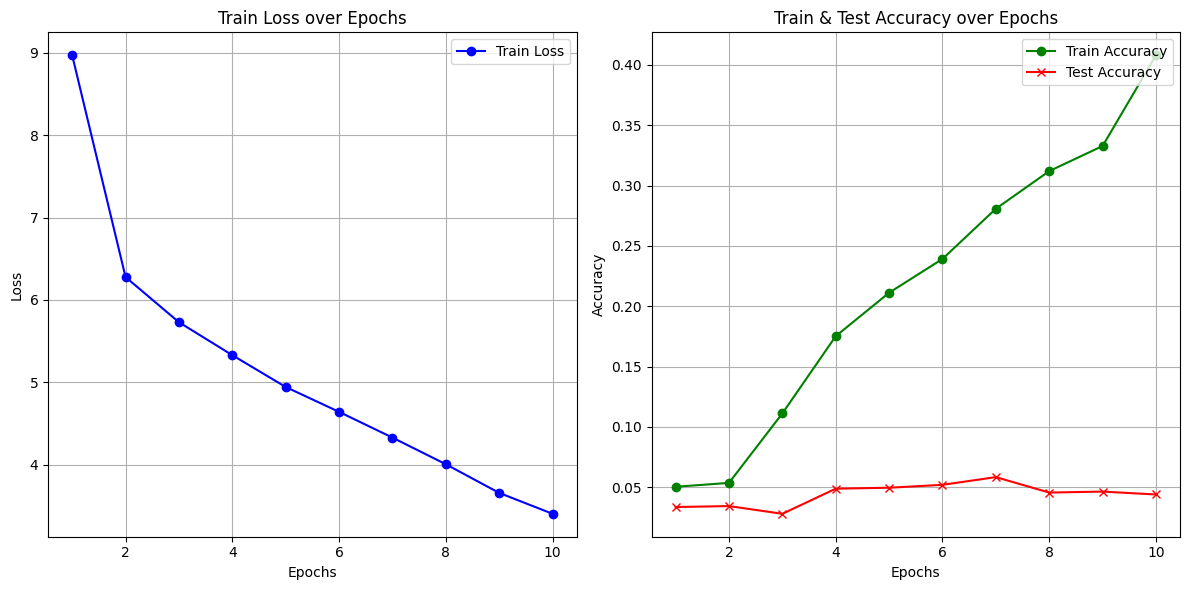

In [12]:
plot_training_results(train_losses, train_accs, test_accs, n_epochs)

### 그래프 분석
* **Train Loss**는 점차적으로 감소하고 있지만, **Train Accuracy**는 급격하게 상승
* **Test Accuracy**는 매우 낮고 불규칙적인 변동을 보임

**개선 사항**
1. dropout_prob 값을 0.2로 변경
2. FFN 차원을 512로 변경
3. epoch를 20으로 변경 하여 학습을 조금 더 진행 시켜 보기
<br/>

`model2 = TextClassifier(len(tokenizer), 256, 5, 512, 0.2)`
`model2 = model2.to('cuda')`

위 코드를 사용해서 train 해보니, Train Loss 10.5026 이 나와서 train_acc, test_acc가 0으로 출력되는 현상 발생